In [1]:
!pip install seaborn
!pip install lazypredict
!pip install optuna

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # General visualisations
import matplotlib.ticker as mtick # Axis visuals
import seaborn as sns # Statistical visualisations
from math import pi # Radar chart support
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix 
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

import tensorflow as tf

# roc_auc_score
plt.style.use('ggplot')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def custom_describe(data):
    # Basic statistics
    desc_stats = data.describe()

    # Missing values count
    missing_values = data.isnull().sum()

    # Unique values count
    unique_values = data.nunique()

    # Identify numeric columns
    numeric_cols = data.select_dtypes(include=['number']).columns

    # Calculate IQR and identify outliers for each numeric column
    outliers = {}
    for col in numeric_cols:
        q1 = desc_stats.loc['25%', col]
        q3 = desc_stats.loc['75%', col]
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers[col] = ((data[col] < lower_bound) | (data[col] > upper_bound)).sum()

    # Get data types for each column
    data_types = data.dtypes
    
    # Combine all information
    custom_description = pd.DataFrame({
        'data_type': data_types,
        'mean': desc_stats.loc['mean'],
        'std': desc_stats.loc['std'],
        'missing_values': missing_values,
        'unique_values': unique_values,
        'outliers': outliers
    })

    return custom_description

# EDA

In [4]:
df = pd.read_csv("/kaggle/input/earthquake-magnitude-damage-and-impact/csv_building_structure.csv",
                     index_col = 'building_id')

In [5]:
print(df.shape)
df.head()

(762106, 30)


,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,...,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,condition_post_eq,damage_grade,technical_solution_proposed
building_id,,,,,,,,,,,,,,,,,,,,,
120101000011,12,1207,120703,1,1,9,288,9,9,Flat,...,0,0,0,1,0,0,0,Damaged-Used in risk,Grade 3,Major repair
120101000021,12,1207,120703,1,1,15,364,9,9,Flat,...,0,0,0,1,0,0,0,Damaged-Repaired and used,Grade 5,Reconstruction
120101000031,12,1207,120703,1,1,20,384,9,9,Flat,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 2,Minor repair
120101000041,12,1207,120703,1,1,20,312,9,9,Flat,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 2,Minor repair
120101000051,12,1207,120703,1,1,30,308,9,9,Flat,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 1,Minor repair


In [6]:
result = custom_describe(df)
result

,data_type,mean,std,missing_values,unique_values,outliers
age_building,int64,24.326405,65.043704,0,176,38050.0
condition_post_eq,object,NaN,NaN,0,8,NaN
count_floors_post_eq,int64,1.252058,1.063275,0,10,454.0
count_floors_pre_eq,int64,2.087783,0.655101,0,9,293993.0
damage_grade,object,NaN,NaN,12,5,NaN
district_id,int64,25.767835,5.807555,0,11,0.0
foundation_type,object,NaN,NaN,0,5,NaN
ground_floor_type,object,NaN,NaN,0,5,NaN
has_superstructure_adobe_mud,int64,0.042401,0.201502,0,2,32314.0
has_superstructure_bamboo,int64,0.080482,0.272039,0,2,61336.0


In [5]:
# Convert data types to categorical
df = df.astype({
    'district_id': 'object', 
    'vdcmun_id': 'object', 
    'ward_id': 'object',
    'has_superstructure_adobe_mud': 'object',
    'has_superstructure_bamboo': 'object',
    'has_superstructure_cement_mortar_brick': 'object',
    'has_superstructure_cement_mortar_stone': 'object',
    'has_superstructure_mud_mortar_brick': 'object',
    'has_superstructure_mud_mortar_stone': 'object',
    'has_superstructure_other': 'object',
    'has_superstructure_rc_engineered': 'object',
    'has_superstructure_rc_non_engineered': 'object',
    'has_superstructure_timber': 'object',
    'has_superstructure_stone_flag': 'object'
})

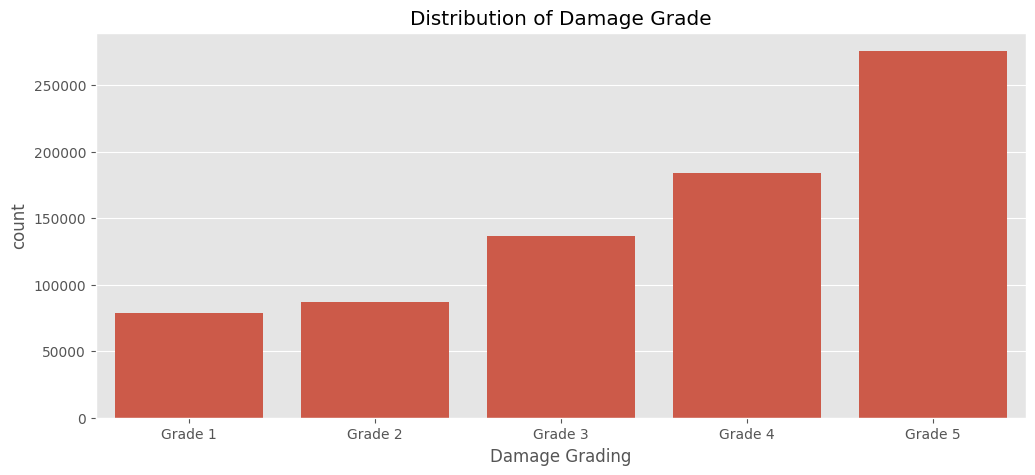

In [8]:
# Exploratory Analysis

plt.figure(figsize=(12,5))
ax = sns.countplot(x='damage_grade', data=df, order = ['Grade 1', 'Grade 2', 'Grade 3', 'Grade 4', 'Grade 5'])
plt.title("Distribution of Damage Grade")
plt.xlabel("Damage Grading")
plt.show()

In [9]:
df.groupby(['district_id','damage_grade']).size().reset_index(name='count').set_index(['district_id', 'damage_grade'])

count
district_id damage_grade       
12          Grade 1        7961
            Grade 2        8605
            Grade 3        9220
            Grade 4        7946
            Grade 5        5620
20          Grade 1       13087
            Grade 2       14469
            Grade 3       17085
            Grade 4       15917
            Grade 5        8191
21          Grade 1        2116
            Grade 2        7151
            Grade 3       16945
            Grade 4       20910
            Grade 5       11490
22          Grade 1        1353
            Grade 2        2993
            Grade 3        6520
            Grade 4       14409
            Grade 5       35364
23          Grade 1        1233
            Grade 2        2009
            Grade 3        3271
            Grade 4       10796
            Grade 5       71432
24          Grade 1        8330
            Grade 2       11726
            Grade 3       25130
            Grade 4       28974
            Grade 5       23859
28          Grade 1        2615
            Grade 2        2745
            Grade 3        8209
            Grade 4       23284
            Grade 5       40295
29          Grade 1         277
            Grade 2         343
            Grade 3         782
            Grade 4        2064
            Grade 5        9178
30          Grade 1        4952
            Grade 2        7526
            Grade 3       15218
            Grade 4       26080
            Grade 5       35346
31          Grade 1       32540
            Grade 2       21135
            Grade 3       18525
            Grade 4       10928
            Grade 5        7866
36          Grade 1        4351
            Grade 2        8555
            Grade 3       15507
            Grade 4       22536
            Grade 5       27125

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


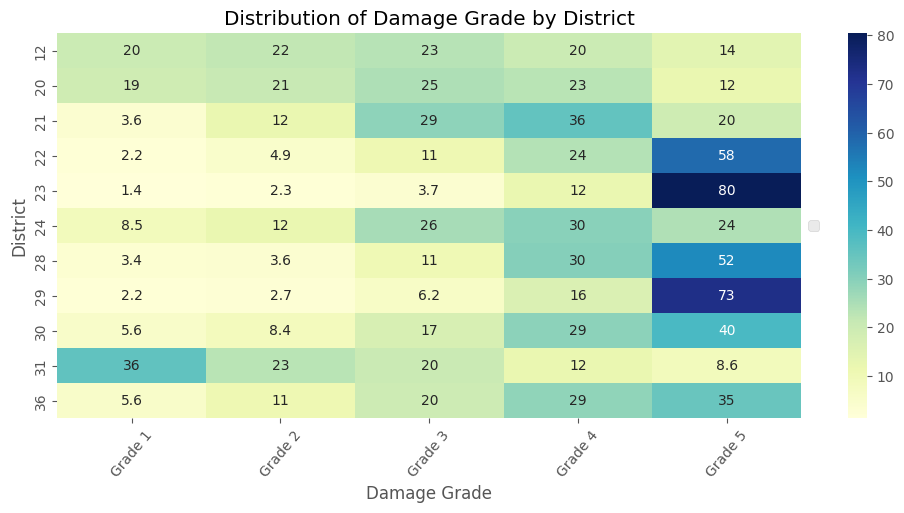

In [10]:
# Calculate counts
df_temp = df.groupby(['district_id', 'damage_grade']).size().reset_index(name='count')

# Calculate Proportion of grade
df_temp['proportion'] = df_temp.groupby('district_id')['count'].transform(lambda x: 100 * x / x.sum())

# Pivot table
df_temp = df_temp.pivot_table(values='proportion', index='district_id', columns='damage_grade')

# Plot chart
plt.figure(figsize=(12, 5))
ax = sns.heatmap(data=df_temp, annot=True, cmap="YlGnBu")
plt.xticks(rotation=50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by District")
plt.xlabel("Damage Grade")
plt.ylabel("District")
plt.show()

# Clean up
del df_temp, ax

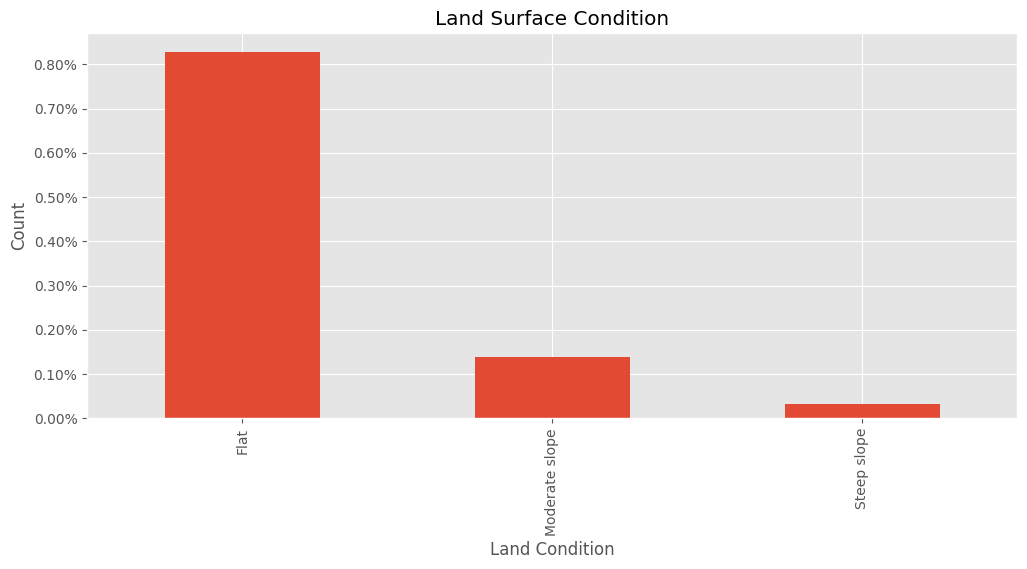

In [11]:
# Create a plot
plt.figure(figsize=(12,5))
ax = df.land_surface_condition.value_counts(normalize = True).plot(kind = "bar")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Land Surface Condition")
plt.ylabel("Count")
plt.xlabel("Land Condition")
plt.show()

# clean script
del ax

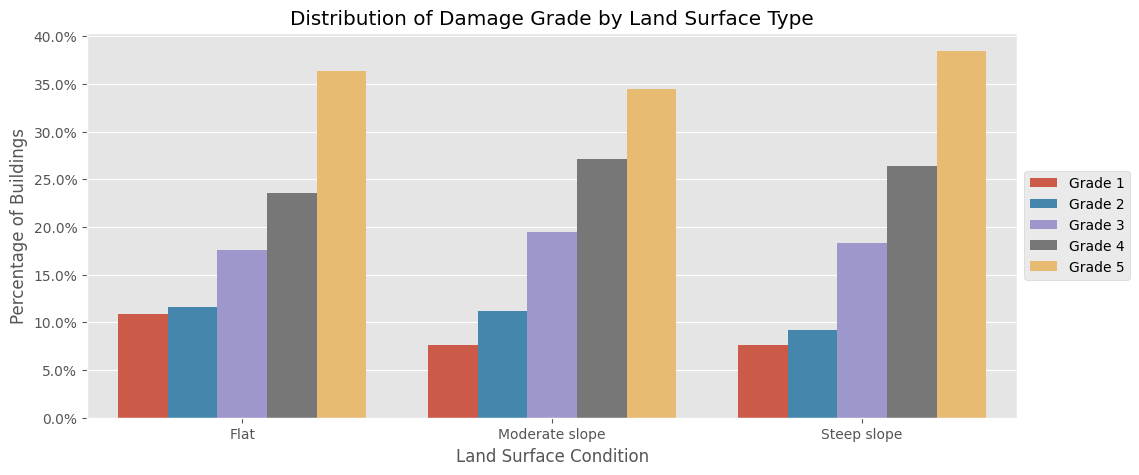

In [12]:
# Calculate counts
df_temp = df.groupby(['land_surface_condition', 'damage_grade']).size().reset_index(name='count')

# Calculate Proportion of grade
df_temp['proportion'] = df_temp.groupby('land_surface_condition')['count'].transform(lambda x: 100 * x / x.sum())

# Plot chart
plt.figure(figsize=(12, 5))
ax = sns.barplot(data=df_temp, 
                 x='land_surface_condition', 
                 y='proportion', 
                 hue='damage_grade')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Land Surface Type")
plt.xlabel("Land Surface Condition")
plt.ylabel("Percentage of Buildings")
plt.show()

# Clean up
del df_temp, ax

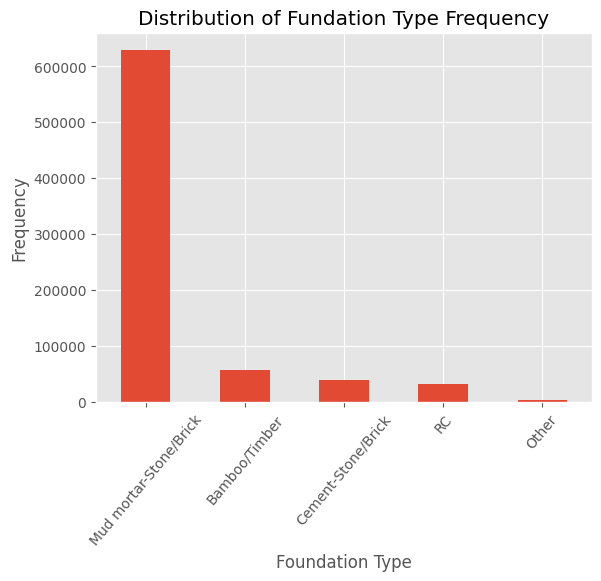

In [13]:
df.foundation_type.value_counts().plot(kind="bar")
plt.xticks(rotation=50)
plt.title("Distribution of Fundation Type Frequency")
plt.xlabel("Foundation Type")
plt.ylabel("Frequency")
plt.show()

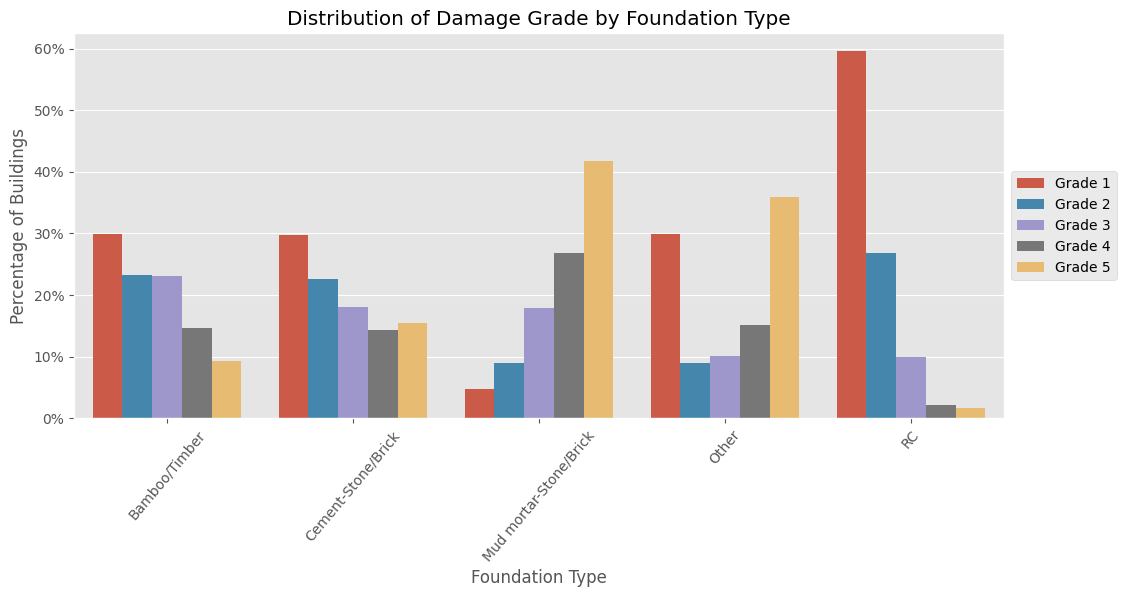

In [14]:
# Calculate counts
df_temp = df.groupby(['foundation_type', 'damage_grade']).size().reset_index(name='count')

# Calculate Proportion of grade
df_temp['proportion'] = df_temp.groupby('foundation_type')['count'].transform(lambda x: 100 * x / x.sum())

# Plot chart
plt.figure(figsize=(12, 5))
ax = sns.barplot(data=df_temp, 
                 x='foundation_type', 
                 y='proportion', 
                 hue='damage_grade')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(rotation=50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Foundation Type")
plt.xlabel("Foundation Type")
plt.ylabel("Percentage of Buildings")
plt.show()

# Clean up
del df_temp, ax

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


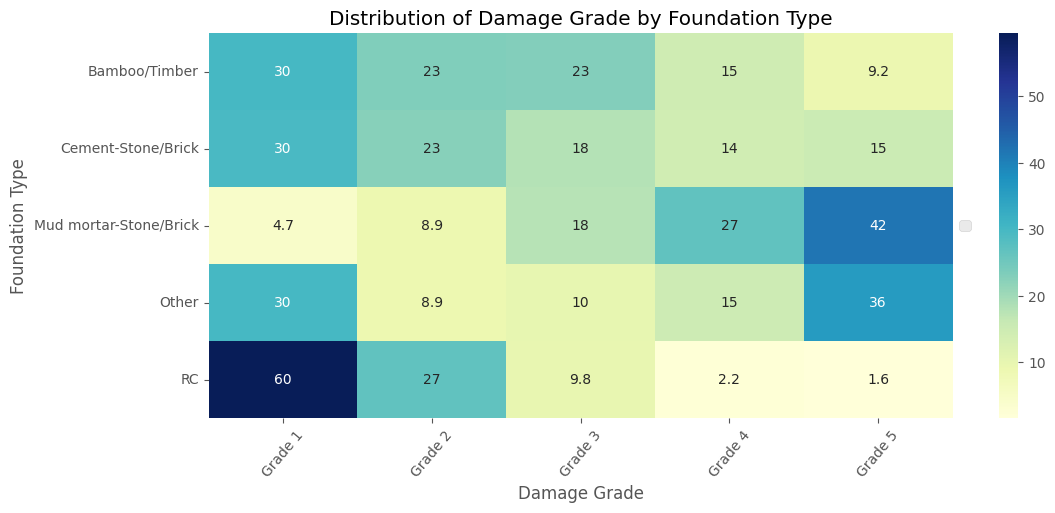

In [15]:
# Calculate counts
df_temp = df.groupby(['foundation_type', 'damage_grade']).size().reset_index(name='count')

# Calculate Proportion of grade
df_temp['proportion'] = df_temp.groupby('foundation_type')['count'].transform(lambda x: 100 * x / x.sum())

# Pivot table
df_temp = pd.pivot_table(df_temp, values='proportion', index=['foundation_type'], columns='damage_grade')

# Plot chart
plt.figure(figsize=(12, 5))
ax = sns.heatmap(data=df_temp, annot=True, cmap="YlGnBu")
plt.xticks(rotation=50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Foundation Type")
plt.xlabel("Damage Grade")
plt.ylabel("Foundation Type")
plt.show()

# Clean up
del df_temp, ax

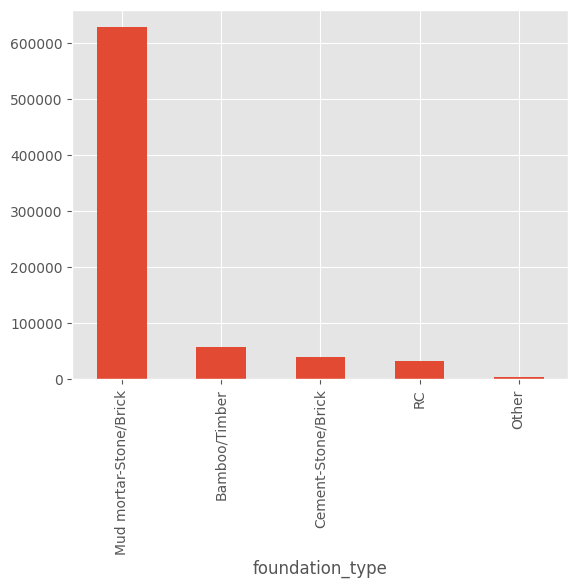

In [16]:
df.foundation_type.value_counts().plot(kind="bar");

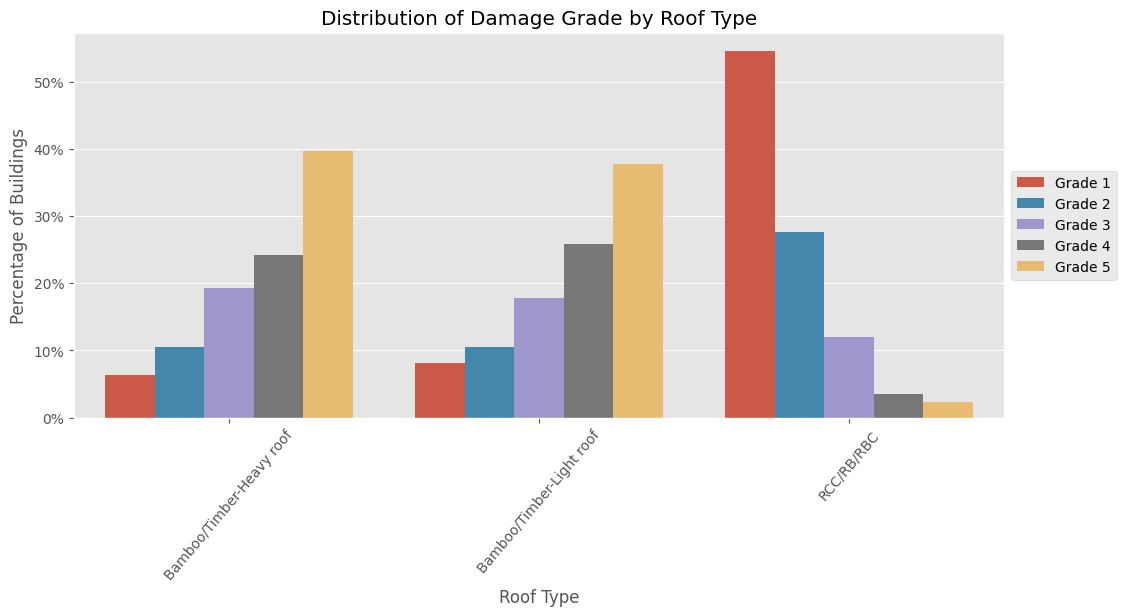

In [17]:
# Calculate counts
df_temp = df.groupby(['roof_type', 'damage_grade']).size().reset_index(name='count')

# Calculate Proportion of grade
df_temp['proportion'] = df_temp.groupby('roof_type')['count'].transform(lambda x: 100 * x / x.sum())

# Plot chart
plt.figure(figsize=(12, 5))
ax = sns.barplot(data=df_temp, 
                 x='roof_type', 
                 y='proportion', 
                 hue='damage_grade')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(rotation=50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Roof Type")
plt.xlabel("Roof Type")
plt.ylabel("Percentage of Buildings")
plt.show()

# Clean up
del df_temp, ax

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


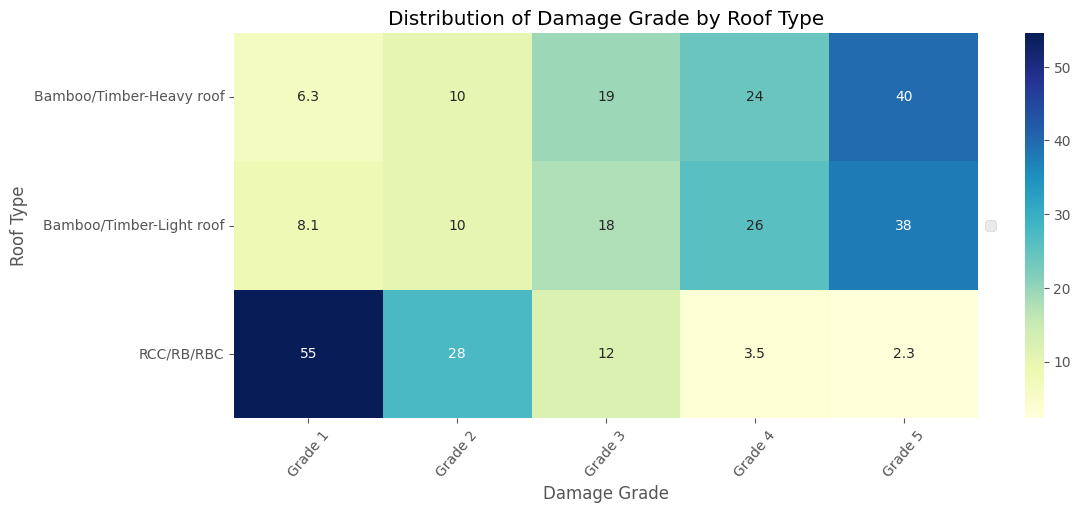

In [18]:
# Calculate counts
df_temp = df.groupby(['roof_type', 'damage_grade']).size().reset_index(name='count')

# Calculate Proportion of grade
df_temp['proportion'] = df_temp.groupby('roof_type')['count'].transform(lambda x: 100 * x / x.sum())

# Pivot table
df_temp = pd.pivot_table(df_temp, values='proportion', index=['roof_type'], columns='damage_grade')

# Plot chart
plt.figure(figsize=(12, 5))
ax = sns.heatmap(data=df_temp, annot=True, cmap="YlGnBu")
plt.xticks(rotation=50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Roof Type")
plt.xlabel("Damage Grade")
plt.ylabel("Roof Type")
plt.show()

# Clean up
del df_temp, ax

# Cleanse

In [6]:
# Drop Nulls
df.dropna(inplace=True)

In [7]:
# Checking for high cardinality columns
df.select_dtypes("object").nunique()

district_id                                11
vdcmun_id                                 110
ward_id                                   945
land_surface_condition                      3
foundation_type                             5
roof_type                                   3
ground_floor_type                           5
other_floor_type                            4
position                                    4
plan_configuration                         10
has_superstructure_adobe_mud                2
has_superstructure_mud_mortar_stone         2
has_superstructure_stone_flag               2
has_superstructure_cement_mortar_stone      2
has_superstructure_mud_mortar_brick         2
has_superstructure_cement_mortar_brick      2
has_superstructure_timber                   2
has_superstructure_bamboo                   2
has_superstructure_rc_non_engineered        2
has_superstructure_rc_engineered            2
has_superstructure_other                    2
condition_post_eq                 

In [8]:
cols_to_drop = ["vdcmun_id", "ward_id"]

In [9]:
# Drop leaky columns, no predictive power!
cols_to_drop+=[col for col in df.columns if "post_eq" in col]
cols_to_drop.append("technical_solution_proposed")

In [10]:
df["plan_configuration"].value_counts()

plan_configuration
Rectangular                        731246
Square                              17576
L-shape                             10079
T-shape                               969
Multi-projected                       940
Others                                518
U-shape                               448
E-shape                               140
Building with Central Courtyard        98
H-shape                                80
Name: count, dtype: int64

In [11]:
cols_to_drop.append("plan_configuration")

In [12]:
# Deciding the target to be (severe=1,not_severe=0)
df["damage_grade"]=df["damage_grade"].str[-1].astype(int)
df["severe_damage"] = (df["damage_grade"] > 3).astype(int)
cols_to_drop.append("damage_grade")

In [13]:
df.drop(columns=cols_to_drop, inplace=True)

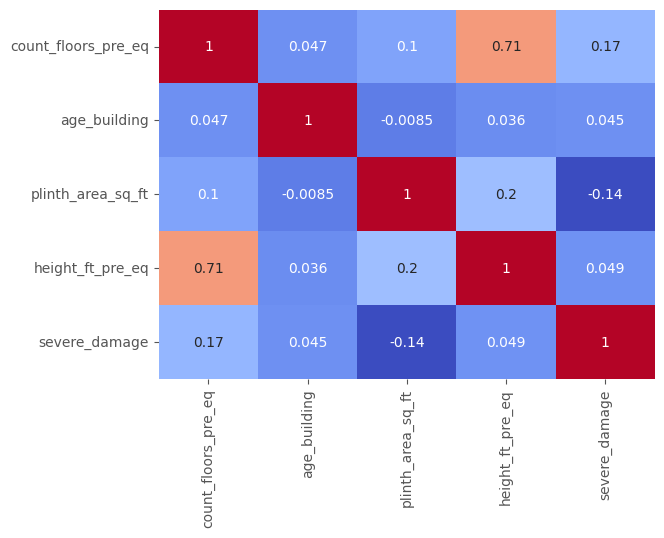

In [14]:
sns.heatmap(df.select_dtypes("number").corr(), cmap='coolwarm', annot=True, cbar=False)
plt.show()

In [15]:
# Drop multi linearity column
df.drop(columns="height_ft_pre_eq", inplace=True)

## Outliers

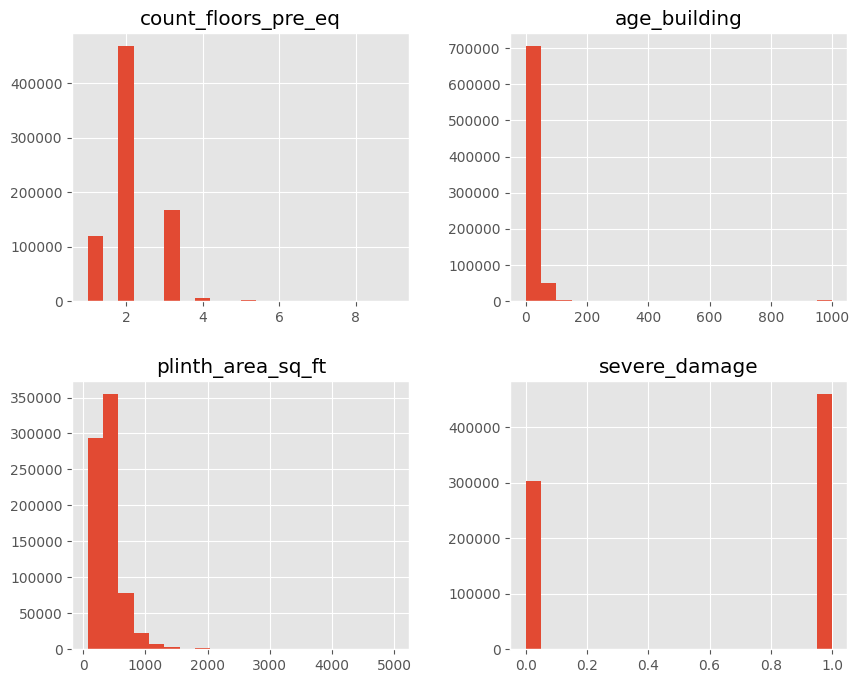

In [16]:
df.hist(figsize=(10, 8), bins=20);

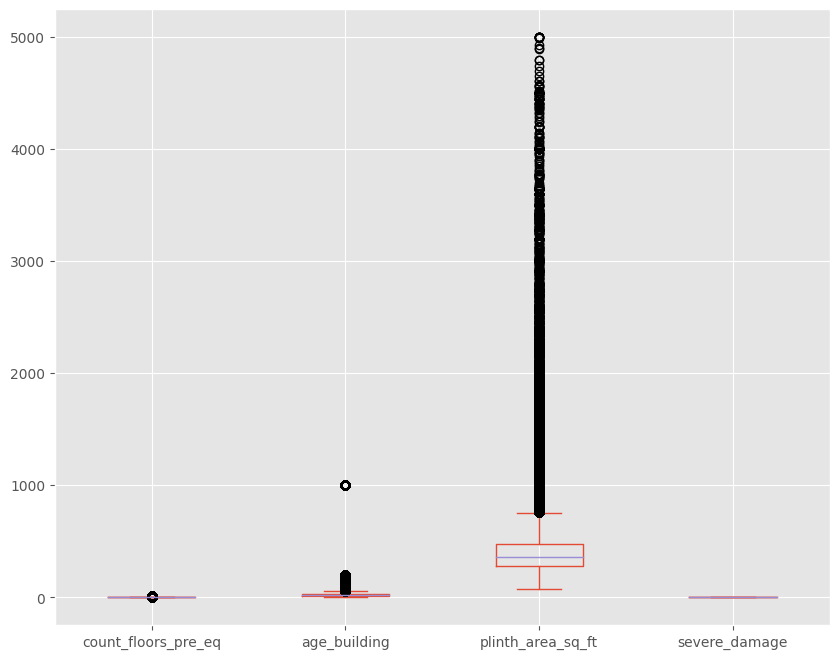

In [17]:
df.plot(kind="box", figsize=(10, 8));

In [18]:
def find_outliers_IQR(df):
    q1=df.quantile(0.15)
    q3=df.quantile(0.75)
    IQR=q3-q1
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    return outliers

In [19]:
# Seeing how many outliers

index = find_outliers_IQR(df["age_building"]).index
print(f"percentage of outliers [age_building] = {round(len(index)/df.shape[0],2)}%") 

df.drop(index, axis=0, inplace=True)


index = find_outliers_IQR(df["plinth_area_sq_ft"]).index
print(f"percentage of outliers [plinth_area_sq_ft] = {round(len(index)/df.shape[0],2)}%") 

df.drop(index, axis=0, inplace=True)

percentage of outliers [age_building] = 0.03%
percentage of outliers [plinth_area_sq_ft] = 0.05%


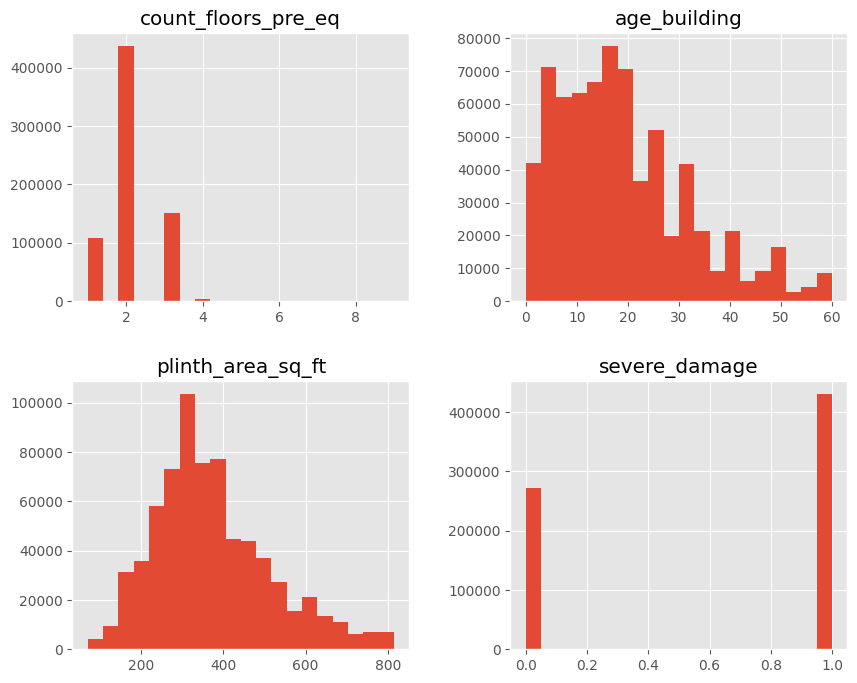

In [20]:
df.hist(figsize=(10, 8), bins=20);

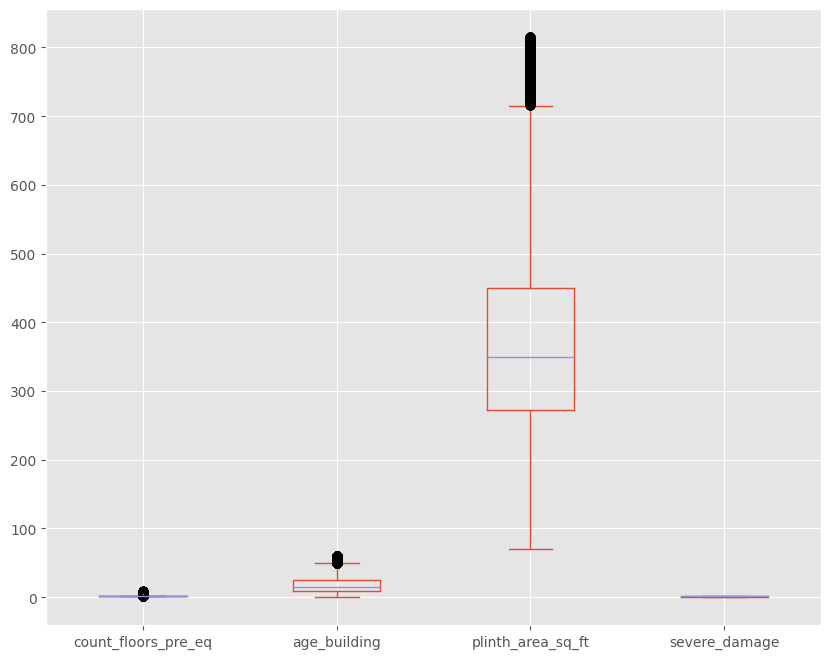

In [21]:
df.plot(kind="box", figsize=(10, 8));

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 702585 entries, 120101000011 to 366709001271
Data columns (total 22 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   district_id                             702585 non-null  object
 1   count_floors_pre_eq                     702585 non-null  int64 
 2   age_building                            702585 non-null  int64 
 3   plinth_area_sq_ft                       702585 non-null  int64 
 4   land_surface_condition                  702585 non-null  object
 5   foundation_type                         702585 non-null  object
 6   roof_type                               702585 non-null  object
 7   ground_floor_type                       702585 non-null  object
 8   other_floor_type                        702585 non-null  object
 9   position                                702585 non-null  object
 10  has_superstructure_adobe_mud            7025

In [23]:
df["district_id"].value_counts()

district_id
24    87637
30    83684
23    81897
31    79082
36    72389
28    71584
20    65337
22    57165
21    55278
12    37145
29    11387
Name: count, dtype: int64

In [24]:
df24 = df[df["district_id"] == 24].drop(columns="district_id")

In [38]:
# df24 = df.copy()

## Split

In [25]:
X = df24.drop('severe_damage', axis = 1)
y = df24['severe_damage']

In [26]:
#  Cre1ate training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.2, 
                                                    random_state = 42, 
                                                    stratify = df24['severe_damage'],
                                                    shuffle=True)

# Calculate proportions on train and test
train_proportions = y_train.value_counts(normalize=True).reset_index(name="train")
test_proportions = y_test.value_counts(normalize=True).reset_index(name="test")

# Merge on the 'damage_grade' column
merged_proportions = pd.merge(train_proportions, test_proportions, on="severe_damage", how="left")

merged_proportions

,severe_damage,train,test
0,1,0.545394,0.545413
1,0,0.454606,0.454587


In [27]:
# Print x train shape before processing
print("Before preprocessing there were {} rows and {} columns".format(*X_train.shape))

# Identify columns
fts_cat = X.select_dtypes('object').columns
fts_num = X.select_dtypes("number").columns

# Create a single Preprocessing step for predictors
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), fts_num), # Centre and scale
        ('ohe', OneHotEncoder(handle_unknown='ignore'), fts_cat), # One Hot encode
    ])
      
# Apply the transformations to both train and test
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.fit_transform(X_test)   

# Print x train shape before processing
print("After preprocessing there are {} rows and {} columns".format(*X_train_transformed.shape))

Before preprocessing there were 70109 rows and 20 columns
After preprocessing there are 70109 rows and 49 columns


# Modeling

## Model Selection using Lazypredict

In [42]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=1, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_transformed, X_test_transformed, y_train, y_test)

  3%|▎         | 1/29 [00:02<01:22,  2.94s/it]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.6523847558192606, 'Balanced Accuracy': 0.6306471702710423, 'ROC AUC': 0.6306471702710423, 'F1 Score': 0.6291201976615391, 'Time taken': 2.941044330596924}


  7%|▋         | 2/29 [00:06<01:28,  3.26s/it]

{'Model': 'BaggingClassifier', 'Accuracy': 0.6190666362391603, 'Balanced Accuracy': 0.6161018026079212, 'ROC AUC': 0.6161018026079212, 'F1 Score': 0.619142327035781, 'Time taken': 3.487109661102295}


 10%|█         | 3/29 [00:06<00:48,  1.87s/it]

{'Model': 'BernoulliNB', 'Accuracy': 0.6444545869465997, 'Balanced Accuracy': 0.6193123435163247, 'ROC AUC': 0.6193123435163246, 'F1 Score': 0.612188947454297, 'Time taken': 0.21902799606323242}


 17%|█▋        | 5/29 [00:09<00:37,  1.54s/it]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.6552373345504335, 'Balanced Accuracy': 0.6322904063954563, 'ROC AUC': 0.6322904063954563, 'F1 Score': 0.6293058438195295, 'Time taken': 2.98228120803833}


 24%|██▍       | 7/29 [00:10<00:19,  1.14it/s]

{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.5976722957553628, 'Balanced Accuracy': 0.5967500756162726, 'ROC AUC': 0.5967500756162727, 'F1 Score': 0.5983605432484207, 'Time taken': 0.6584939956665039}
{'Model': 'DummyClassifier', 'Accuracy': 0.5454130534002738, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.38497849900373726, 'Time taken': 0.13286852836608887}


 28%|██▊       | 8/29 [00:10<00:14,  1.48it/s]

{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.5980716567777271, 'Balanced Accuracy': 0.5962279557560788, 'ROC AUC': 0.5962279557560788, 'F1 Score': 0.5985643656318145, 'Time taken': 0.24419617652893066}


 34%|███▍      | 10/29 [00:22<00:56,  2.96s/it]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.6226038338658147, 'Balanced Accuracy': 0.6172754301725731, 'ROC AUC': 0.6172754301725731, 'F1 Score': 0.6215549836195551, 'Time taken': 11.931549072265625}
{'Model': 'GaussianNB', 'Accuracy': 0.6404039251483341, 'Balanced Accuracy': 0.6086080724571927, 'ROC AUC': 0.6086080724571927, 'F1 Score': 0.5855437774257819, 'Time taken': 0.1876082420349121}


 38%|███▊      | 11/29 [00:23<00:40,  2.23s/it]

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.6316179826563213, 'Balanced Accuracy': 0.6236894229638218, 'ROC AUC': 0.6236894229638218, 'F1 Score': 0.6287419532872778, 'Time taken': 0.5695807933807373}


 41%|████▏     | 12/29 [03:30<16:33, 58.47s/it]

{'Model': 'LabelPropagation', 'Accuracy': 0.6477635782747604, 'Balanced Accuracy': 0.6319386857051638, 'ROC AUC': 0.6319386857051636, 'F1 Score': 0.635624382028579, 'Time taken': 187.09593653678894}


 45%|████▍     | 13/29 [07:28<30:03, 112.70s/it]

{'Model': 'LabelSpreading', 'Accuracy': 0.6489046097672295, 'Balanced Accuracy': 0.6327443665876897, 'ROC AUC': 0.6327443665876897, 'F1 Score': 0.636255696475426, 'Time taken': 237.48902249336243}


 48%|████▊     | 14/29 [07:28<19:41, 78.79s/it] 

{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.6530123231401187, 'Balanced Accuracy': 0.6269798860714826, 'ROC AUC': 0.6269798860714826, 'F1 Score': 0.6188503263533507, 'Time taken': 0.4168269634246826}


 52%|█████▏    | 15/29 [07:54<14:41, 62.94s/it]

{'Model': 'LinearSVC', 'Accuracy': 0.6526129621177544, 'Balanced Accuracy': 0.6266033275360857, 'ROC AUC': 0.6266033275360857, 'F1 Score': 0.61848619511773, 'Time taken': 26.208526849746704}


 55%|█████▌    | 16/29 [07:55<09:34, 44.17s/it]

{'Model': 'LogisticRegression', 'Accuracy': 0.6549520766773163, 'Balanced Accuracy': 0.6295523096570381, 'ROC AUC': 0.6295523096570381, 'F1 Score': 0.6227013459667313, 'Time taken': 0.5832931995391846}


 59%|█████▊    | 17/29 [07:55<06:11, 30.95s/it]

{'Model': 'NearestCentroid', 'Accuracy': 0.646223185759927, 'Balanced Accuracy': 0.6204007452403757, 'ROC AUC': 0.6204007452403757, 'F1 Score': 0.6121622254192468, 'Time taken': 0.20952725410461426}


 62%|██████▏   | 18/29 [57:12<2:46:53, 910.32s/it]

{'Model': 'NuSVC', 'Accuracy': 0.6083979917845732, 'Balanced Accuracy': 0.6079307291929223, 'ROC AUC': 0.6079307291929222, 'F1 Score': 0.6091207487786948, 'Time taken': 2957.416574239731}


 66%|██████▌   | 19/29 [57:13<1:46:10, 637.02s/it]

{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.5649246919214971, 'Balanced Accuracy': 0.5726123636806641, 'ROC AUC': 0.5726123636806641, 'F1 Score': 0.5631699399507087, 'Time taken': 0.33985233306884766}


 69%|██████▉   | 20/29 [57:13<1:06:52, 445.86s/it]

{'Model': 'Perceptron', 'Accuracy': 0.61296211775445, 'Balanced Accuracy': 0.6009544979079497, 'ROC AUC': 0.6009544979079497, 'F1 Score': 0.6057739815998878, 'Time taken': 0.3213653564453125}


 72%|███████▏  | 21/29 [57:14<41:37, 312.15s/it]  

{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.5749657690552259, 'Balanced Accuracy': 0.5708137991295728, 'ROC AUC': 0.5708137991295728, 'F1 Score': 0.574683936904868, 'Time taken': 0.4226415157318115}


 79%|███████▉  | 23/29 [57:23<15:29, 154.98s/it]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.6299064354176175, 'Balanced Accuracy': 0.6244924782813261, 'ROC AUC': 0.6244924782813261, 'F1 Score': 0.6287934520930277, 'Time taken': 9.551409721374512}
{'Model': 'RidgeClassifier', 'Accuracy': 0.6530123231401187, 'Balanced Accuracy': 0.6269589865739107, 'ROC AUC': 0.6269589865739107, 'F1 Score': 0.618790681955029, 'Time taken': 0.1965794563293457}


 83%|████████▎ | 24/29 [57:24<09:02, 108.60s/it]

{'Model': 'RidgeClassifierCV', 'Accuracy': 0.6530123231401187, 'Balanced Accuracy': 0.6269589865739107, 'ROC AUC': 0.6269589865739107, 'F1 Score': 0.618790681955029, 'Time taken': 0.40514087677001953}


 86%|████████▌ | 25/29 [57:25<05:05, 76.27s/it] 

{'Model': 'SGDClassifier', 'Accuracy': 0.6406891830214514, 'Balanced Accuracy': 0.6113984179395405, 'ROC AUC': 0.6113984179395406, 'F1 Score': 0.5951757395392854, 'Time taken': 0.8498506546020508}


 90%|████████▉ | 26/29 [1:06:02<10:25, 208.55s/it]

{'Model': 'SVC', 'Accuracy': 0.6663623916020082, 'Balanced Accuracy': 0.642792193880123, 'ROC AUC': 0.642792193880123, 'F1 Score': 0.6395724792361234, 'Time taken': 517.1574420928955}


 97%|█████████▋| 28/29 [1:06:03<01:52, 112.57s/it]

{'Model': 'XGBClassifier', 'Accuracy': 0.6629963486992241, 'Balanced Accuracy': 0.6467391007544824, 'ROC AUC': 0.6467391007544824, 'F1 Score': 0.6505214587896723, 'Time taken': 1.2246930599212646}
[LightGBM] [Info] Number of positive: 38237, number of negative: 31872
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 464
[LightGBM] [Info] Number of data points in the train set: 70109, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.545394 -> initscore=0.182076
[LightGBM] [Info] Start training from score 0.182076


100%|██████████| 29/29 [1:06:04<00:00, 136.70s/it]

{'Model': 'LGBMClassifier', 'Accuracy': 0.6668188041989959, 'Balanced Accuracy': 0.647651747155988, 'ROC AUC': 0.647651747155988, 'F1 Score': 0.6494581407245619, 'Time taken': 0.7059156894683838}


In [43]:
print(models)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.67               0.65     0.65      0.65   
XGBClassifier                      0.66               0.65     0.65      0.65   
SVC                                0.67               0.64     0.64      0.64   
LabelSpreading                     0.65               0.63     0.63      0.64   
CalibratedClassifierCV             0.66               0.63     0.63      0.63   
LabelPropagation                   0.65               0.63     0.63      0.64   
AdaBoostClassifier                 0.65               0.63     0.63      0.63   
LogisticRegression                 0.65               0.63     0.63      0.62   
LinearDiscriminantAnalysis         0.65               0.63     0.63      0.62   
RidgeClassifier                    0.65               0.63     0.63      0.62   
RidgeClassifierCV           

## LGBM

In [35]:
import lightgbm as lgb

Test Accuracy of random forest Model:  67.37 %

Train Accuracy of random forest Model:  68.89 %



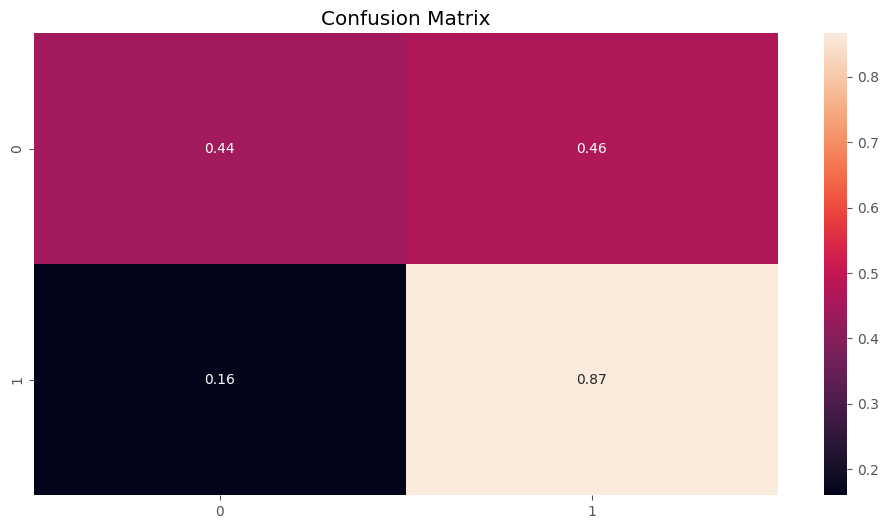

In [37]:
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier())
])

lgbm.fit(X_train, y_train) # fit model
y_pred = lgbm.predict(X_test) # predict on test

# Calculate confusion matrix
con_mat = confusion_matrix(y_test, y_pred)
con_mat = con_mat / con_mat.astype(float).sum(axis=1)


print('Test Accuracy of random forest Model: ',round(100*lgbm.score(X_test, y_test),2),'%')
print('')
print('Train Accuracy of random forest Model: ',round(100*lgbm.score(X_train, y_train),2),'%')
print('')

# Plot Model
plt.figure(figsize = (12,6))
ax = sns.heatmap(con_mat, annot = True)
plt.title("Confusion Matrix")
plt.show()

In [48]:
def objective(trial):
    params = {
        "n_estimators" : trial.suggest_int('n_estimators', 100, 1000),
        "max_depth" : trial.suggest_int('max_depth', 6, 64),
        #"num_leaves": trial.suggest_int("num_leaves", 2, 32),
        #"learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
    }

    lgbm = lgb.LGBMClassifier(**params, n_jobs=-1)
    lgbm.fit(X_train_transformed, y_train)
    
    y_pred = lgbm.predict(X_test_transformed)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300)

[I 2023-12-18 20:21:18,900] A new study created in memory with name: no-name-aed9f635-e1b3-4aad-a6e8-98ae0cd6fc0e
[I 2023-12-18 20:21:20,828] Trial 0 finished with value: 0.6641373801916933 and parameters: {'n_estimators': 587, 'max_depth': 54}. Best is trial 0 with value: 0.6641373801916933.
[I 2023-12-18 20:21:22,386] Trial 1 finished with value: 0.6636809675947056 and parameters: {'n_estimators': 447, 'max_depth': 14}. Best is trial 0 with value: 0.6641373801916933.
[I 2023-12-18 20:21:24,724] Trial 2 finished with value: 0.6601437699680511 and parameters: {'n_estimators': 711, 'max_depth': 29}. Best is trial 0 with value: 0.6641373801916933.
[I 2023-12-18 20:21:26,395] Trial 3 finished with value: 0.6651643085349156 and parameters: {'n_estimators': 498, 'max_depth': 43}. Best is trial 3 with value: 0.6651643085349156.
[I 2023-12-18 20:21:27,135] Trial 4 finished with value: 0.6702418986764035 and parameters: {'n_estimators': 184, 'max_depth': 61}. Best is trial 4 with value: 0.6702

In [49]:
best_params = study.best_params
print("Best Parameters:", best_params)

# Train the final model with the best parameters
final_lgbm = lgb.LGBMClassifier(**best_params)
final_lgbm.fit(X_train_transformed, y_train)
y_pred_final = final_lgbm.predict(X_test_transformed)
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final Accuracy with Optuna: {final_accuracy}")

Best Parameters: {'n_estimators': 180, 'max_depth': 45}
Final Accuracy with Optuna: 0.6702989502510269


## XGBoost

In [50]:
import xgboost as xgb

Test Accuracy of random forest Model:  67.75 %

Train Accuracy of random forest Model:  70.91 %



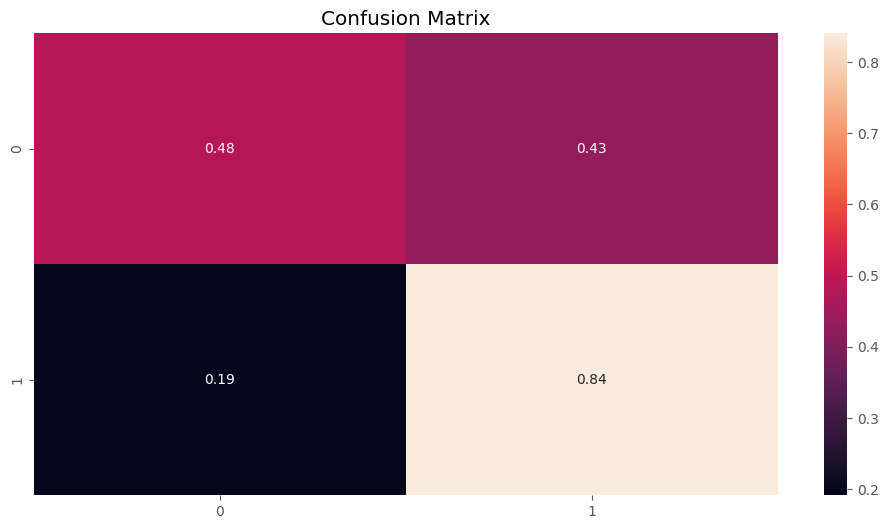

In [51]:
xgbo = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier())
])

xgbo.fit(X_train, y_train) # fit model
y_pred = xgbo.predict(X_test) # predict on test

# Calculate confusion matrix
con_mat = confusion_matrix(y_test, y_pred)
con_mat = con_mat / con_mat.astype(float).sum(axis=1)


print('Test Accuracy of random forest Model: ',round(100*xgbo.score(X_test, y_test),2),'%')
print('')
print('Train Accuracy of random forest Model: ',round(100*xgbo.score(X_train, y_train),2),'%')
print('')

# Plot Model
plt.figure(figsize = (12,6))
ax = sns.heatmap(con_mat, annot = True)
plt.title("Confusion Matrix")
plt.show()

In [52]:
def objective(trial):
    params = {
        "n_estimators" : trial.suggest_int('n_estimators', 100, 1000),
        "max_depth" : trial.suggest_int('max_depth', 6, 64),
        #"learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
    }
    
    xgb_classifier = xgb.XGBClassifier(**params, n_jobs=-1)
    xgb_classifier.fit(X_train_transformed, y_train)
    
    y_pred = xgb_classifier.predict(X_test_transformed)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300)

[I 2023-12-18 20:26:14,357] A new study created in memory with name: no-name-3ff0cdf2-bd1d-4e11-a7ba-b1b7a9c70b57
[I 2023-12-18 20:26:42,315] Trial 0 finished with value: 0.6110794157918759 and parameters: {'n_estimators': 793, 'max_depth': 49}. Best is trial 0 with value: 0.6110794157918759.
[I 2023-12-18 20:27:05,553] Trial 1 finished with value: 0.613076220903697 and parameters: {'n_estimators': 572, 'max_depth': 53}. Best is trial 1 with value: 0.613076220903697.
[I 2023-12-18 20:27:30,056] Trial 2 finished with value: 0.6130191693290735 and parameters: {'n_estimators': 734, 'max_depth': 43}. Best is trial 1 with value: 0.613076220903697.
[I 2023-12-18 20:27:41,239] Trial 3 finished with value: 0.6036627110908261 and parameters: {'n_estimators': 484, 'max_depth': 26}. Best is trial 1 with value: 0.613076220903697.
[I 2023-12-18 20:27:53,827] Trial 4 finished with value: 0.615073026015518 and parameters: {'n_estimators': 269, 'max_depth': 54}. Best is trial 4 with value: 0.615073026

In [53]:
best_params = study.best_params
print("Best Parameters:", best_params)

# Train the final model with the best parameters
final_xgb = xgb.XGBClassifier(**best_params)
final_xgb.fit(X_train_transformed, y_train)
y_pred_final = final_xgb.predict(X_test_transformed)
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final Accuracy with Optuna: {final_accuracy}")

Best Parameters: {'n_estimators': 614, 'max_depth': 6}
Final Accuracy with Optuna: 0.630591054313099


## Random Forest

In [ ]:
rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf.fit(X_train, y_train) # fit model
y_pred = rf.predict(X_test) # predict on test

# Calculate confusion matrix
con_mat = confusion_matrix(y_test, y_pred)
con_mat = con_mat / con_mat.astype(float).sum(axis=1)


print('Test Accuracy of random forest Model: ',round(100*rf.score(X_test, y_test),2),'%')
print('')
print('Train Accuracy of random forest Model: ',round(100*rf.score(X_train, y_train),2),'%')
print('')

# Plot Model
plt.figure(figsize = (12,6))
ax = sns.heatmap(con_mat, annot = True)
plt.title("Confusion Matrix")
plt.show()

Test Accuracy of random forest Model:  67.43 %

Train Accuracy of random forest Model:  71.12 %



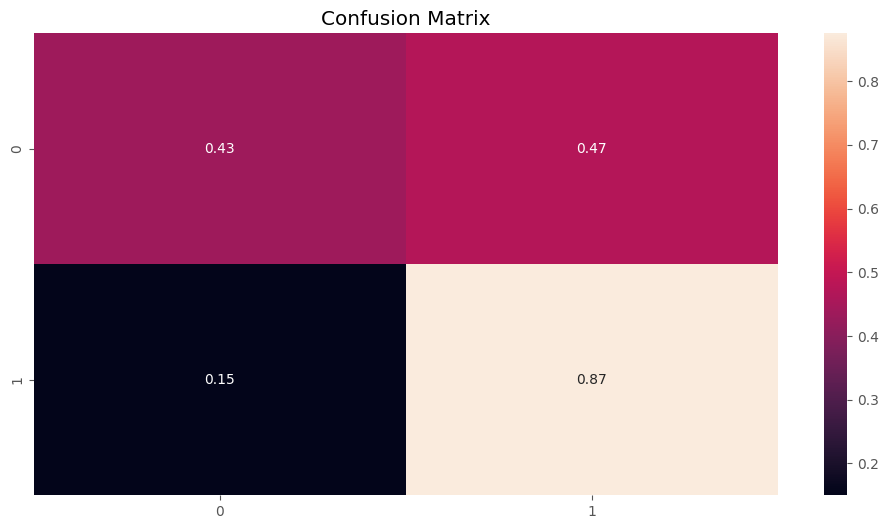

In [44]:
rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=263,
        max_depth=31,
        min_samples_split=2,
        min_samples_leaf=4,
        random_state=42
    ))
])

rf.fit(X_train, y_train) # fit model
y_pred = rf.predict(X_test) # predict on test

# Calculate confusion matrix
con_mat = confusion_matrix(y_test, y_pred)
con_mat = con_mat / con_mat.astype(float).sum(axis=1)


print('Test Accuracy of random forest Model: ',round(100*rf.score(X_test, y_test),2),'%')
print('')
print('Train Accuracy of random forest Model: ',round(100*rf.score(X_train, y_train),2),'%')
print('')

# Plot Model
plt.figure(figsize = (12,6))
ax = sns.heatmap(con_mat, annot = True)
plt.title("Confusion Matrix")
plt.show()

In [54]:
import optuna

def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 2, 16, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)

    # Create the Random Forest Classifier with the suggested hyperparameters
    random_forest = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Train the model
    random_forest.fit(X_train_transformed, y_train)

    # Make predictions on the test set
    y_pred = random_forest.predict(X_test_transformed)

    # Calculate accuracy as the objective to optimize
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # You can adjust the number of trials

[I 2023-12-18 21:15:11,625] A new study created in memory with name: no-name-66c07fb5-60c1-42b2-8d69-45627f671aa1
[I 2023-12-18 21:15:13,620] Trial 0 finished with value: 0.6482770424463715 and parameters: {'n_estimators': 73, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.6482770424463715.
[I 2023-12-18 21:15:39,880] Trial 1 finished with value: 0.6687585577361935 and parameters: {'n_estimators': 465, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.6687585577361935.
[I 2023-12-18 21:15:52,091] Trial 2 finished with value: 0.6474783204016431 and parameters: {'n_estimators': 451, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.6687585577361935.
[I 2023-12-18 21:16:00,409] Trial 3 finished with value: 0.6426859881332725 and parameters: {'n_estimators': 369, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.

In [57]:
best_params = study.best_params
print("Best Parameters:", best_params)

# Train the final model with the best parameters
final_rf = RandomForestClassifier(**best_params)
final_rf.fit(X_train_transformed, y_train)
y_pred_final = final_rf.predict(X_test_transformed)
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final Accuracy with Optuna: {final_accuracy}")

Best Parameters: {'n_estimators': 488, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 1}
Final Accuracy with Optuna: 0.6725810132359653


## Bagging

Idea: Train multiple instances of the same model on different subsets of the training data and combine their predictions.

In [33]:
from sklearn.ensemble import BaggingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

# Define base models
lgbm_model = LGBMClassifier(random_state=42)

xgb_model = XGBClassifier(random_state=42)

rf_model = RandomForestClassifier(
    n_estimators=488, 
    max_depth= 16, 
    min_samples_split= 7, 
    min_samples_leaf= 1,
    random_state=42
)

In [34]:
# Create bagging classifiers
lgbm_bagging = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', BaggingClassifier(base_estimator=lgbm_model, n_estimators=30, random_state=42))
])
xgb_bagging = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', BaggingClassifier(base_estimator=xgb_model, n_estimators=30, random_state=42))
])

rf_bagging = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', BaggingClassifier(base_estimator=rf_model, n_estimators=30, random_state=42))
])

# Train the bagging models
lgbm_bagging.fit(X_train, y_train)
xgb_bagging.fit(X_train, y_train)
rf_bagging.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  Index(['count_floors_pre_eq', 'age_building', 'plinth_area_sq_ft'], dtype='object')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'has_superstructure...
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other'],
      dtype='object'))])),
                ('classifier',
                 BaggingClassifier(base_estimator=RandomForestClassifier(max_depth=16,
                                                                         min_samples_split=7,
                                                                         n_estimators=488,
                                                                         random_state=42),
                                   n_estimators=30, random_state=42))])

In [35]:
print('Test Accuracy of LGBM Model: ',round(100*lgbm_bagging.score(X_test, y_test),2),'%')
print('')
print('Train Accuracy of LGBM Model: ',round(100*lgbm_bagging.score(X_train, y_train),2),'%')
print('')

print('Test Accuracy of XGB Model: ',round(100*xgb_bagging.score(X_test, y_test),2),'%')
print('')
print('Train Accuracy of XGB Model: ',round(100*xgb_bagging.score(X_train, y_train),2),'%')
print('')

print('Test Accuracy of random forest Model: ',round(100*rf_bagging.score(X_test, y_test),2),'%')
print('')
print('Train Accuracy of random forest Model: ',round(100*rf_bagging.score(X_train, y_train),2),'%')
print('')

Test Accuracy of LGBM Model:  67.49 %

Train Accuracy of LGBM Model:  68.89 %

Test Accuracy of XGB Model:  67.78 %

Train Accuracy of XGB Model:  71.2 %

Test Accuracy of random forest Model:  67.11 %

Train Accuracy of random forest Model:  70.08 %



## Boosting

Idea: Train models sequentially, where each model corrects the errors of the previous one.

In [36]:
# Create boosting classifiers
lgbm_boosting = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(base_estimator=lgbm_model, n_estimators=50, random_state=42))
])

xgb_boosting = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=50, random_state=42))
])

rf_boosting = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(base_estimator=rf_model, n_estimators=50, random_state=42))
])

# Train the boosting models
lgbm_boosting.fit(X_train, y_train)
xgb_boosting.fit(X_train, y_train)
rf_boosting.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  Index(['count_floors_pre_eq', 'age_building', 'plinth_area_sq_ft'], dtype='object')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'has_superstructure...
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other'],
      dtype='object'))])),
                ('classifier',
                 AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=16,
                                                                          min_samples_split=7,
                                                                          n_estimators=488,
                                                                          random_state=42),
                                    random_state=42))])

In [37]:
print('Test Accuracy of LGBM Model: ',round(100*lgbm_boosting.score(X_test, y_test),2),'%')
print('')
print('Train Accuracy of LGBM Model: ',round(100*lgbm_boosting.score(X_train, y_train),2),'%')
print('')

print('Test Accuracy of XGB Model: ',round(100*xgb_boosting.score(X_test, y_test),2),'%')
print('')
print('Train Accuracy of XGB Model: ',round(100*xgb_boosting.score(X_train, y_train),2),'%')
print('')

print('Test Accuracy of random forest Model: ',round(100*rf_boosting.score(X_test, y_test),2),'%')
print('')
print('Train Accuracy of random forest Model: ',round(100*rf_boosting.score(X_train, y_train),2),'%')
print('')

Test Accuracy of LGBM Model:  66.5 %

Train Accuracy of LGBM Model:  75.64 %

Test Accuracy of XGB Model:  65.82 %

Train Accuracy of XGB Model:  66.12 %

Test Accuracy of random forest Model:  65.72 %

Train Accuracy of random forest Model:  85.24 %



## Stacking

Idea: Train multiple models and use another model (meta-model) to combine their predictions.

In [38]:
# Create a stacking classifier
stacked_model = StackingClassifier(
    estimators=[('lgbm', lgbm_model), ('xgb', xgb_model), ('rf', rf_model)],
    final_estimator=LGBMClassifier(random_state=42),
    stack_method='auto',
    cv=5
)

# Train the stacking model
stacked_model.fit(X_train_transformed, y_train)

# Make predictions
stacked_preds = stacked_model.predict(X_test_transformed)

In [39]:
print('Test Accuracy of Stacked Models: ',round(100*stacked_model.score(X_test_transformed, y_test),2),'%')
print('')
print('Train Accuracy of Stacked Models: ',round(100*stacked_model.score(X_train_transformed, y_train),2),'%')
print('')

Test Accuracy of Stacked Models:  66.75 %

Train Accuracy of Stacked Models:  70.85 %



## Voting

Idea: Combine the predictions of multiple models by averaging (soft voting) or taking a majority vote (hard voting).

In [40]:
# Create a voting classifier
voting_model = VotingClassifier(
    estimators=[('lgbm', lgbm_model), ('xgb', xgb_model), ('rf', rf_model)],
    voting='soft'  # 'hard' for majority voting
)

# Train the voting model
voting_model.fit(X_train_transformed, y_train)

# Make predictions
voting_preds = voting_model.predict(X_test_transformed)

In [41]:
print('Test Accuracy of Voting Models: ',round(100*voting_model.score(X_test_transformed, y_test),2),'%')
print('')
print('Train Accuracy of Voting Models: ',round(100*voting_model.score(X_train_transformed, y_train),2),'%')
print('')

Test Accuracy of Voting Models:  67.16 %

Train Accuracy of Voting Models:  70.43 %

